In [ ]:
# %% [markdown]
"""
# 01_curve_qc.py — lightweight QC notebook

VS Code treats `# %%` blocks as Jupyter cells, so you can **Run All** or step
through interactively.  The notebook

* stitches **curve_history.parquet** and **curve_live.parquet**
* derives simple features (level & slope)
* fetches daily BTC‑USD prices from Yahoo Finance
* plots funding‑level vs. price and a slope ↔ next‑day‑return scatter.

Place this file at **project‑root/notebooks/01_curve_qc.py**.
"""
# %%
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
# %% [markdown]

In [ ]:
# %%  Load curve snapshots  -------------------------------
from pathlib import Path
import pandas as pd
from pandas.tseries.frequencies import to_offset

ROOT = Path.cwd()                 # notebook’s working dir  ← fix
# If you always launch VS Code from the project root, this is correct.
# Otherwise:  ROOT = Path(__file__).parents[2]  ← works in .py script, not notebook

curve_hist_path = ROOT / "storage" / "processed" / "curve_history.parquet"
curve_live_path = ROOT / "storage" / "processed" / "curve_live.parquet"

# read history
df_curve = pd.read_parquet(curve_hist_path, engine="fastparquet")
if curve_live_path.exists():
    df_curve = pd.concat(
        [df_curve, pd.read_parquet(curve_live_path, engine="fastparquet")],
        ignore_index=True,
    )

df_curve["ts_snap"] = pd.to_datetime(df_curve["ts_snap"], utc=True)
df_curve = df_curve.sort_values("ts_snap")

# choose a single exchange (Binance) for first pass
curve_bn = df_curve[df_curve["exchange"] == "binance"].copy()

# tidy → wide: one column per bucket
curve_w = (
    curve_bn.pivot_table(
        index="ts_snap", columns="bucket_start_h", values="fwd_rate_ann"
    )
    .add_prefix("b_")
    .sort_index()
)

# basic derived factors
curve_w["level"] = curve_w["b_0"]
curve_w["slope"] = curve_w["b_56"] - curve_w["b_0"]
curve_w = curve_w.dropna(subset=["level", "slope"])  # ensure complete rows
# %% [markdown]

In [ ]:
# %%  Download BTC close & attach to every bucket row  -----------------------

import pandas as pd
import yfinance as yf
from datetime import timedelta

# --- B1.  download BTC-USD closes ------------------------------------------
start_date = curve_w.index.get_level_values(0).min().strftime("%Y-%m-%d")
end_date   = (curve_w.index.get_level_values(0).max() + timedelta(days=1)).strftime("%Y-%m-%d")

btc = (
    yf.download("BTC-USD", start=start_date, end=end_date, progress=False)
      .loc[:, ["Close"]]
      .rename(columns={"Close": "btc_close"})
)
btc.index = btc.index.tz_localize("UTC")

# --- B2.  broadcast price to MultiIndex ------------------------------------
btc_aligned = btc.reindex(curve_w.index.get_level_values(0), method="ffill")

curve_full = curve_w.copy()
curve_full["btc_close"]  = btc_aligned.values
curve_full["btc_ret_1d"] = curve_full["btc_close"].pct_change().shift(-1)

display(curve_full.head(12))    # shows 8 buckets per ts_snap


,b_0,b_8,b_16,b_24,b_32,b_40,b_48,b_56,level,slope,BTC-USD,btc_close,btc_ret_1d
ts_snap,,,,,,,,,,,,,
2021-01-03 08:00:00+00:00,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,2.510388,0.0,32782.023438,32782.023438,0.000000
2021-01-03 16:00:00.002000+00:00,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,4.452104,0.0,32782.023438,32782.023438,-0.024712
2021-01-04 00:00:00+00:00,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,5.023729,0.0,31971.914062,31971.914062,0.000000
2021-01-04 08:00:00+00:00,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,12.282148,0.0,31971.914062,31971.914062,0.000000
2021-01-04 16:00:00+00:00,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.848783,0.0,31971.914062,31971.914062,0.063197
2021-01-05 00:00:00.020000+00:00,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,1.629711,0.0,33992.429688,33992.429688,0.000000
2021-01-05 08:00:00.003000+00:00,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.675893,0.0,33992.429688,33992.429688,0.000000
2021-01-05 16:00:00.003000+00:00,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.990891,0.0,33992.429688,33992.429688,0.083311
2021-01-06 00:00:00.010000+00:00,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,3.022398,0.0,36824.363281,36824.363281,0.000000


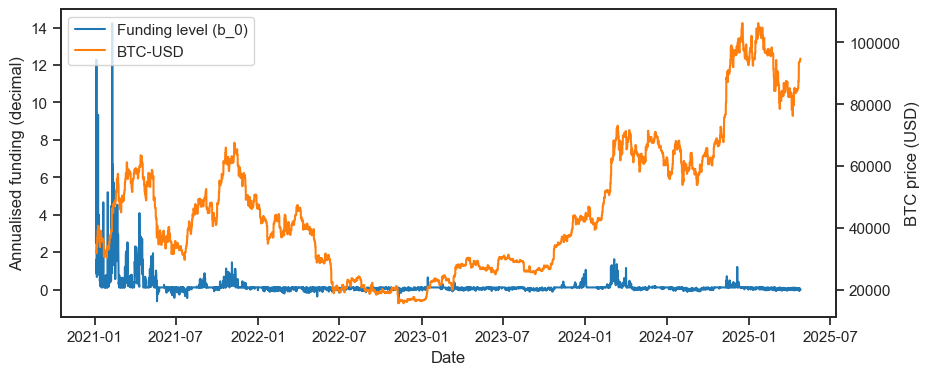

In [ ]:
# %% Plot bucket-0 funding level vs. BTC price  -----------------------------
import matplotlib.pyplot as plt

# 1) make a tidy DataFrame with just the two series we need
plot_df = (
    curve_full[["b_0", "btc_close"]]
      .rename(columns={"b_0": "funding_b0_ann"})
)

# 2) build dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(plot_df.index, plot_df["funding_b0_ann"],
         label="Funding level (b_0)", color="tab:blue")
ax2.plot(plot_df.index, plot_df["btc_close"],
         label="BTC-USD", color="tab:orange")

ax1.set_ylabel("Annualised funding (decimal)")
ax2.set_ylabel("BTC price (USD)")
ax1.set_xlabel("Date")

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()



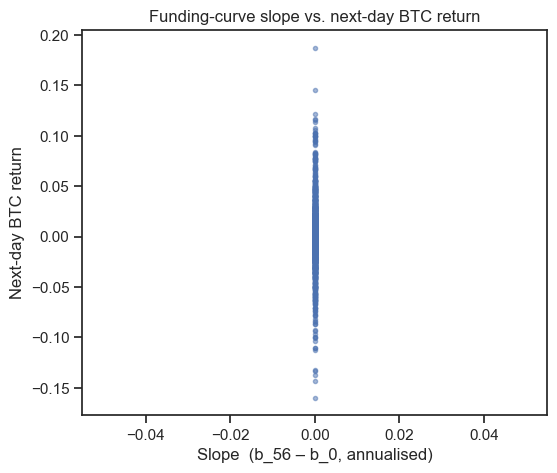

Notebook finished ✅ – curves, price, and scatter plotted.


In [ ]:
# %% Plot 2 – funding-slope vs. next-day BTC return  ------------------------
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# 0.  Ensure helper columns exist
# --------------------------------------------------------------------------
if "slope" not in curve_full.columns:
    curve_full["slope"] = curve_full["b_56"] - curve_full["b_0"]

if "btc_ret_1d" not in curve_full.columns:
    curve_full["btc_ret_1d"] = curve_full["btc_close"].pct_change().shift(-1)

# --------------------------------------------------------------------------
# 1.  Build a tidy DataFrame with *one row per timestamp*
#     • If index has 2 levels, pick bucket-0 rows.
#     • If index has 1 level, use the frame as-is.
# --------------------------------------------------------------------------
if curve_full.index.nlevels == 2:
    bucket0_mask = curve_full.index.get_level_values(1) == 0
    tidy_df = (
        curve_full[bucket0_mask]
          .droplevel(1)           # drop bucket level
          .reset_index()          # ts_snap -> column
    )
else:  # already single-level
    tidy_df = curve_full.reset_index()

# --------------------------------------------------------------------------
# 2.  Scatter plot
# --------------------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(tidy_df["slope"], tidy_df["btc_ret_1d"], alpha=0.5, s=9)
plt.xlabel("Slope  (b_56 – b_0, annualised)")
plt.ylabel("Next-day BTC return")
plt.title("Funding-curve slope vs. next-day BTC return")

finite_mask = np.isfinite(tidy_df["slope"]) & np.isfinite(tidy_df["btc_ret_1d"])
x = tidy_df.loc[finite_mask, "slope"].values
y = tidy_df.loc[finite_mask, "btc_ret_1d"].values

if len(np.unique(x)) > 1:                    # need ≥2 distinct x values
    m, b = np.polyfit(x, y, deg=1)
    xg   = np.linspace(x.min(), x.max(), 200)
    plt.plot(xg, m * xg + b,
             color="tab:red", lw=0.8, alpha=0.8, label="OLS trend")
    plt.legend(loc="upper left")
# ------------------------------------

plt.show()
print("Notebook finished ✅ – curves, price, and scatter plotted.")



Loading feature store from storage/processed/feature_store.parquet using Polars...
Loaded 6843 rows into Polars DataFrame.
Converted Polars DataFrame to Pandas DataFrame (6843 rows).
Plotting pairplot on 2000 sampled rows.


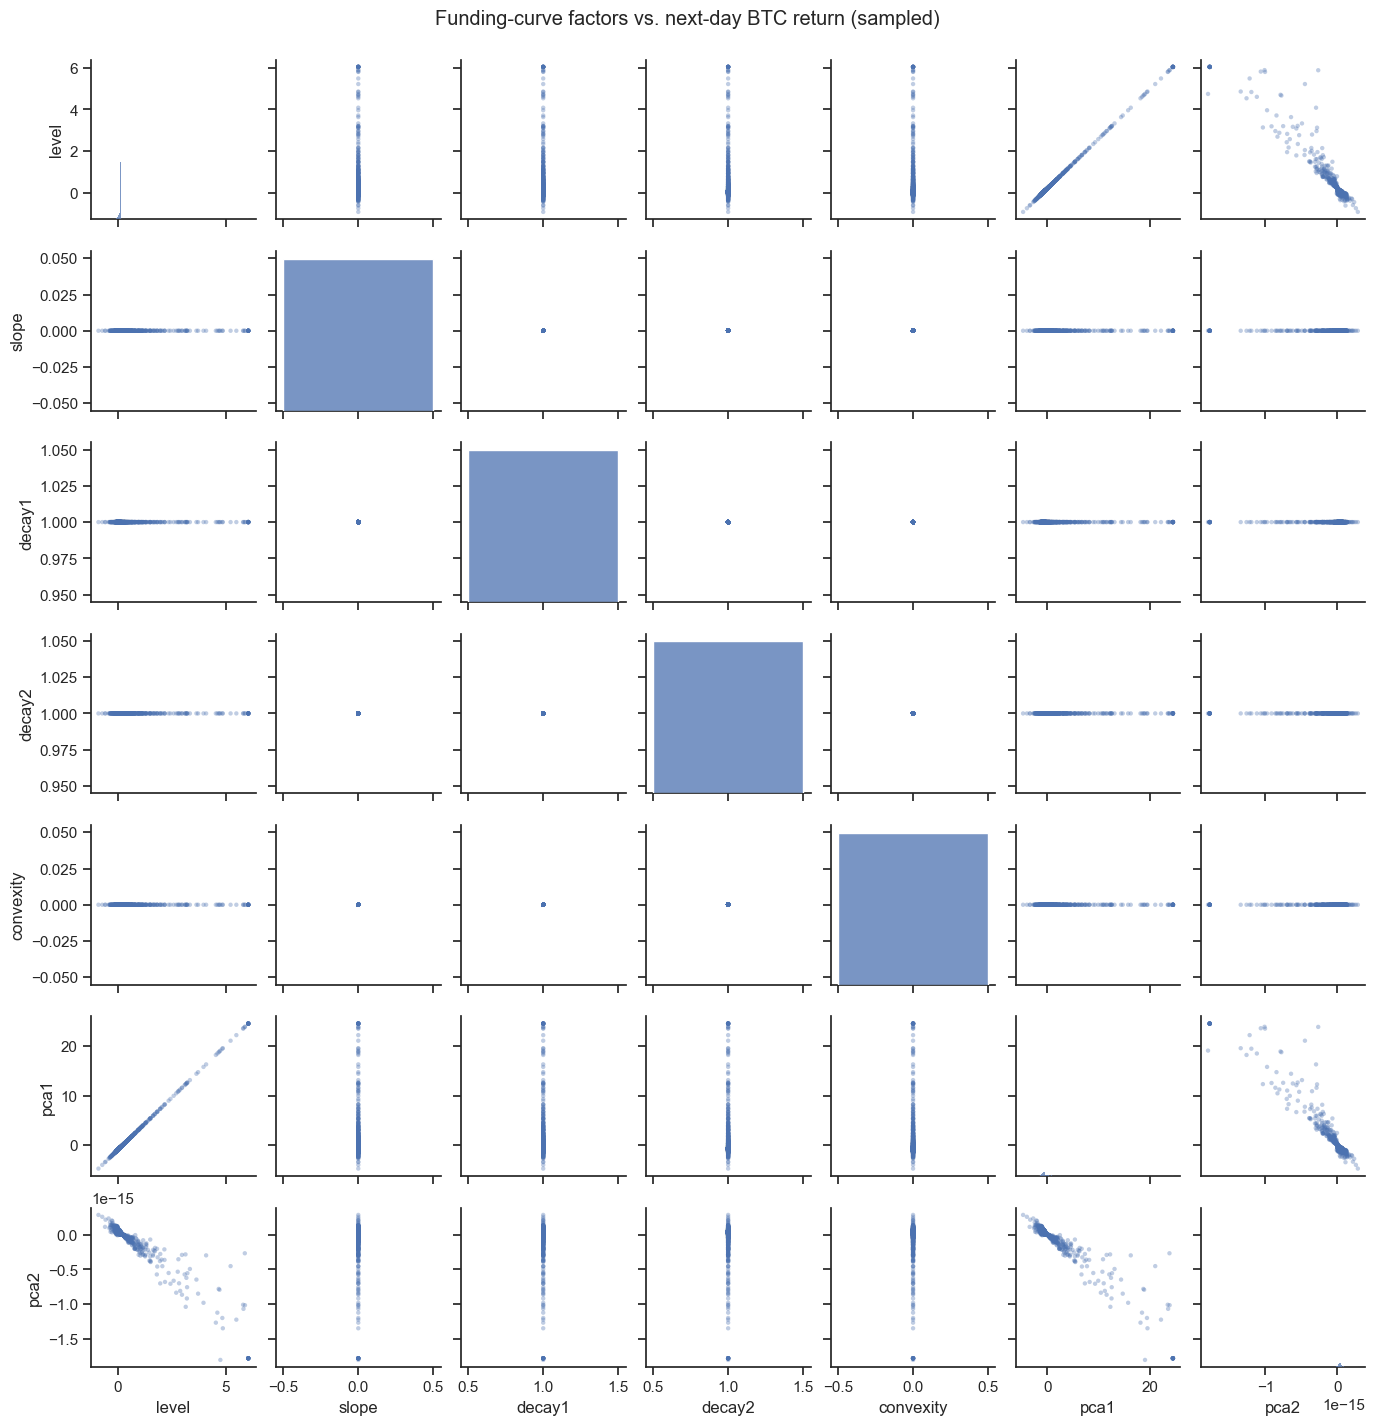

Pairplot generated.
Calculating and plotting correlation heatmap...


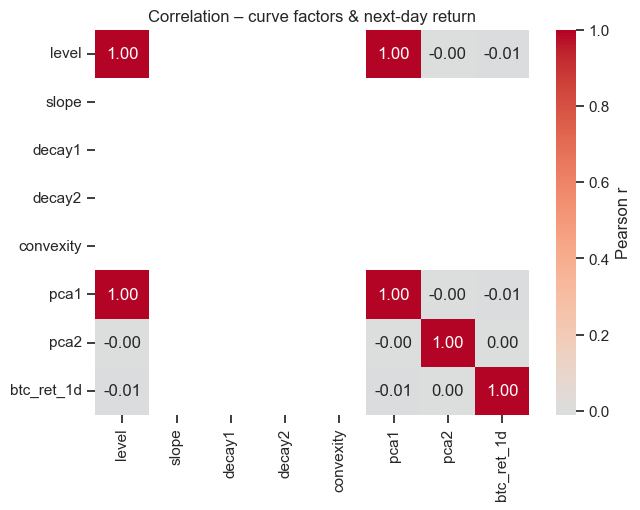

Correlation heatmap generated.
Plotting time-series ribbon of z-scored factors...


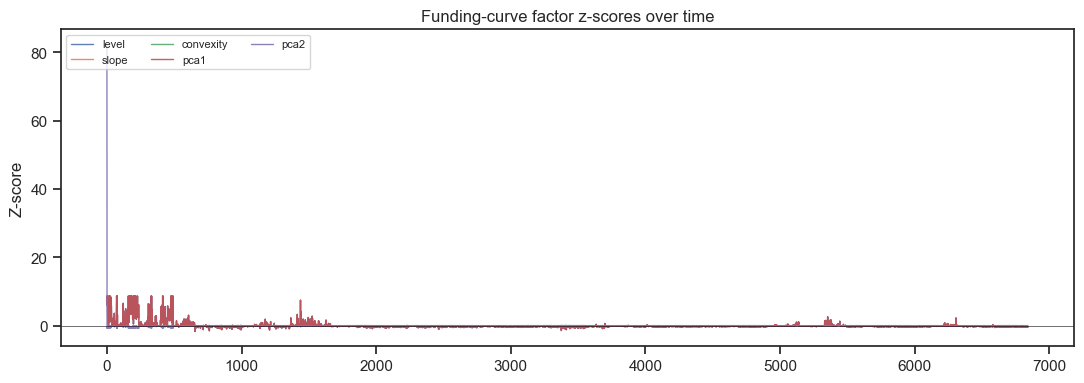

Time-series ribbon generated.

Notebook cell finished ✅ – plots should be displayed above.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="ticks")
import polars as pl # <-- Import Polars
from pathlib import Path # <-- ADDED THIS IMPORT!

# ------------------------------------------------------------------ #
# 1.  Load feature store using Polars (lazy/efficient read)
# ------------------------------------------------------------------ #
# Use Polars to read the parquet file efficiently.
# We'll keep it in Polars for as long as possible.
feature_store_path = "storage/processed/feature_store.parquet"

# Check if the file exists before trying to read
if not Path(feature_store_path).exists():
    print(f"Error: Feature store file not found at {feature_store_path}")
    print("Please run feature_build.py first to generate the feature store.")
    # Stop execution of the cell or notebook if run as a script
    raise FileNotFoundError(f"Feature store file not found: {feature_store_path}")

print(f"Loading feature store from {feature_store_path} using Polars...")
# Use scan_parquet for lazy evaluation - particularly useful for very large files
# If the file size is manageable (tens/hundreds of MBs), read_parquet is also fast.
# Let's start with a direct read for simplicity in this plot cell.
try:
    # Use columns argument to load only necessary columns if memory is still an issue
    required_cols = ["level","slope","decay1","decay2","convexity","pca1","pca2","btc_ret_1d"]
    feat_pl = pl.read_parquet(feature_store_path, columns=required_cols)
    print(f"Loaded {len(feat_pl)} rows into Polars DataFrame.")

    # Convert ts_snap to datetime index if it exists and isn't already
    # Polars often keeps timestamp as a column unless explicitly set as index
    if "ts_snap" in feat_pl.columns:
         # Convert to datetime with timezone for consistent plotting
         # Polars handles timezone info, ensure it's UTC if that's how you saved it
         feat_pl = feat_pl.with_columns(
             pl.col("ts_snap").cast(pl.Datetime(time_unit="us", time_zone="UTC")) # Adjust time_unit if needed
         )
         # Set ts_snap as the index for plotting purposes if needed by libraries
         # For many plotting scenarios, just sorting by ts_snap is sufficient
         # Let's keep it as a column for now, converting to Pandas will handle index

    # Convert to Pandas DataFrame ONLY when needed for plotting libraries
    feat = feat_pl.to_pandas()
    # Ensure the ts_snap is the index after converting to pandas for time series plots
    if 'ts_snap' in feat.columns:
        feat = feat.set_index('ts_snap')
    print(f"Converted Polars DataFrame to Pandas DataFrame ({len(feat)} rows).")

except Exception as e:
    print(f"Error loading or converting feature store: {e}")
    # Stop execution if there's an error
    raise

# Ensure 'btc_ret_1d' exists after loading and conversion (should be there if feature_build ran)
if "btc_ret_1d" not in feat.columns:
     print("Error: 'btc_ret_1d' column not found in feature store!")
     print("Please ensure feature_build.py is correctly calculating and saving this column.")
     raise ValueError("'btc_ret_1d' not in feature store.")


# ------------------------------------------------------------------ #
# 2.  Pair-scatter grid (sample for speed)
# ------------------------------------------------------------------ #
SAMPLE_N = 2_000
# Sample directly from the Pandas DataFrame now that it's loaded
if len(feat) > SAMPLE_N:
    plot_df  = feat.sample(n=SAMPLE_N, random_state=42)
else:
    plot_df = feat # Use all data if less than sample size

print(f"Plotting pairplot on {len(plot_df)} sampled rows.")
g = sns.pairplot(
    plot_df,
    vars=["level", "slope", "decay1", "decay2", "convexity", "pca1", "pca2"],
    y_vars=["btc_ret_1d"],
    height=2.0, aspect=1,
    plot_kws=dict(alpha=0.35, s=10, edgecolor="none"),
)
g.fig.suptitle("Funding-curve factors vs. next-day BTC return (sampled)",
               y=1.02)
plt.show()
print("Pairplot generated.")


# ------------------------------------------------------------------ #
# 3.  Correlation heat-map (on full loaded data)
# ------------------------------------------------------------------ #
print("Calculating and plotting correlation heatmap...")
corr = feat[["level","slope","decay1","decay2",
             "convexity","pca1","pca2","btc_ret_1d"]].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            cbar_kws=dict(label="Pearson r"))
plt.title("Correlation – curve factors & next-day return")
plt.show()
print("Correlation heatmap generated.")


# ------------------------------------------------------------------ #
# 4.  Time-series ribbon (Z-scored factors)
# ------------------------------------------------------------------ #
print("Plotting time-series ribbon of z-scored factors...")
# Ensure the index is sorted by time for time series plotting
if not feat.index.is_monotonic_increasing:
    feat = feat.sort_index()

z_factors = (feat[["level","slope","convexity","pca1","pca2"]]
             .apply(lambda s: (s - s.mean()) / s.std()))

plt.figure(figsize=(11,4))
for col in z_factors.columns:
    plt.plot(z_factors.index, z_factors[col],
             label=col, lw=1, alpha=0.9)
plt.axhline(0, color="black", lw=0.4)
plt.ylabel("Z-score")
plt.title("Funding-curve factor z-scores over time")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout()
plt.show()
print("Time-series ribbon generated.")

print("\nNotebook cell finished ✅ – plots should be displayed above.")

# %%

In [13]:
df = pd.read_parquet("storage/processed/curve_history.parquet",
                     engine="fastparquet")
wide = df.pivot(index="ts_snap", columns="bucket_start_h", values="fwd_rate_ann")
wide = wide.sort_index().dropna()

print("bucket std-dev (ann %):")
print((wide.std() * 100).round(4))          # expect ~0.00–0.02 for b_8…b_56

ValueError: Index contains duplicate entries, cannot reshape